In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 2.8MB/s 
     |████████████████████████████████| 512kB 31.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7962dffe7fd99b48b0194c92d7542a6b635d385716d675508d3ce4433e2dbe44
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tenso

##Import Libraries 

In [ ]:
import pandas as pd, numpy as np, tensorflow as tf
from tensorflow.contrib import rnn


In [ ]:
import numpy as np
import sklearn
import pandas as pd
import warnings
%reload_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
df_train_re.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_input_train.csv',index=False)
train_target_re.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_output_train.csv',index=False)
df_val_re.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_input_val.csv',index=False)
val_target_re.to_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_output_val.csv',index=False)

In [ ]:
df_data = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/Input_pca_0.95thres.csv')
df_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,PTID_Key,EXAMDATE,DX
0,-0.914682,-0.601231,-1.025777,0.646176,1.011424,0.545620,0.413133,0.157729,0.240342,1.240933,-0.614915,1.991610,0.506536,0.278690,0.153647,-0.377177,1.514802,-0.019620,0.283497,-0.656795,0.221551,0.350008,0.196467,-0.604921,-1.521657,-0.185724,-1.876779,-0.208486,0.673291,-0.596495,0.631191,0.029072,0.877182,-0.778522,0.761286,-1.076368,-0.941719,0.219719,2.491332,-1.257230,...,0.240799,-0.403455,-0.313444,-0.471123,1.063699,-0.801149,-0.386264,0.054835,0.332211,-2.399556,1.094873,2.336983,-2.151991,0.262187,0.434412,1.312646,-1.291214,0.415570,-1.990970,-1.362115,-0.359844,-0.691137,0.531001,0.796599,0.538899,0.668736,-0.362717,0.526381,-1.574725,1.199216,0.881033,-0.162544,1.078744,1.362077,1.059333,0.267904,-0.928759,1.0,2010-12-10,2
1,-0.551814,-0.979159,-1.117663,1.076771,0.625453,0.594147,0.200665,-0.109799,0.167253,1.085187,-0.908410,0.744116,0.728125,-0.159216,0.144665,0.513853,1.799283,-0.349975,0.227961,-0.650050,0.099265,0.732234,0.033733,-0.569960,-1.853381,0.309617,-1.390592,-0.524115,0.653087,0.003768,1.020155,-0.361017,1.143764,-0.811648,0.879657,-0.934078,-0.719017,-0.174933,1.807723,-0.246274,...,-0.597084,-0.788613,-0.759914,-0.559378,0.918252,-0.153937,-0.072157,0.764843,0.574582,-1.299033,1.859001,0.993939,-0.972449,1.815612,-0.805537,1.022320,-1.829569,0.756406,-0.444980,-2.338430,0.632880,-0.912492,1.094919,0.033690,0.674762,0.643271,-0.362390,0.543195,-1.660143,1.020524,1.949152,-0.949106,-0.750425,0.614402,1.703636,-0.747710,-0.966335,1.0,2011-04-07,2
2,-0.819792,-0.982411,-1.010481,1.050002,0.690168,0.794730,0.281609,-0.584068,0.522935,1.314278,-0.468990,1.015674,0.095780,-0.090131,0.121122,0.641263,1.195369,-0.043699,0.300918,-0.510973,0.033367,0.266118,0.286762,-0.413685,-1.853315,0.160174,-1.505841,-0.255259,1.073686,-0.130857,0.113276,-0.490394,0.355425,-1.346322,0.936334,-1.610474,-0.638695,-0.203596,1.830329,-0.354029,...,-0.035952,0.708540,0.377110,0.002219,1.057412,0.114082,-0.368786,-0.383575,0.110381,-1.250354,-0.132147,0.602319,-0.741663,1.161139,0.772682,0.659802,-0.370310,0.504005,-1.390165,-1.299680,-0.612009,-1.319248,-0.379710,0.861513,0.097416,1.025970,0.005399,0.394066,-0.682618,1.512006,0.429191,-0.094298,0.603369,0.183042,0.871928,0.794578,0.589846,1.0,2011-09-08,2
3,-1.336588,0.124982,0.265170,0.702093,-0.806993,0.915643,-0.873193,0.532319,-1.443681,0.450639,-0.561673,-0.045912,0.461204,-0.131562,0.077892,-0.862214,0.354069,-0.058075,-0.284119,-2.005307,-0.728140,-0.122163,0.388809,-0.725412,-0.164666,-0.481027,-0.053525,1.137394,-0.665674,-0.085696,0.019830,-0.143032,0.536505,-0.038190,0.683802,0.057937,-0.216116,-0.079253,0.046781,-0.709941,...,-0.922823,0.459259,0.136026,0.516101,-1.122543,-1.276170,0.537032,-0.185670,-0.037686,0.163978,1.703618,-0.464324,-0.760336,0.292739,-0.525850,1.064035,-1.654064,-0.097459,-0.879186,0.406081,-0.507800,-0.140618,0.504883,1.182153,1.805809,-0.803499,0.384380,-0.600851,0.237532,2.262692,1.360018,0.069672,0.544021,-1.105401,0.759985,1.659128,-0.180586,2.0,2006-07-21,0
4,-1.562420,0.529299,0.027853,0.916200,-1.044956,1.685090,-0.881126,0.370308,-0.712720,-0.208872,-0.542123,0.410522,0.639658,0.323089,0.323216,-0.525278,0.635510,0.016097,-0.366100,-2.154320,-0.987386,-0.190409,-0.108063,-0.892028,0.631797,-0.194658,-0.279678,1.133721,-1.076537,-0.565393,1.026210,-0.527438,0.445320,-0.061565,0.775616,-0.266960,-0.385827,-0.361899,-0.194316,0.149040,...,-0.602299,0.342353,-0.407926,2.106130,-0.573788,-0.499155,0.522528,-0.143081,0.093791,-1.170585,1.653108,-0.311750,-0.543931,-1.058488,-1.638842,-0.074263,-1.314339,-0.251519,-0.417725,1.145915,0.412533,-0.835132,1.147302,0.691795,0.688599,-0.304910,0.089377,-0.876775,-0.559781,2.978864,0.207917,-0.230468,1.791909,-0.

In [ ]:
train_target = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/train_preprocessed.csv')
train_target.head()

,Date,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE
0,2013-03-28,8,0.0,1.0,0.0,5.0,0.012128,30.0
1,2013-10-31,8,0.0,1.0,0.0,5.0,0.012128,30.0
2,2014-04-28,8,0.0,1.0,0.0,5.0,0.012128,30.0
3,2013-02-04,18,0.0,1.0,0.0,9.0,0.020526,30.0
4,2013-09-03,18,0.0,1.0,0.0,10.5,0.020526,29.5


In [ ]:
val_target = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/val_preprocessed.csv')
val_target.head()

,Date,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE
0,2013-02-13,5,1.0,0.0,0.0,16.0,0.019279,28.0
1,2013-08-14,5,0.5,0.5,0.0,19.5,0.019279,27.5
2,2014-02-20,5,0.0,1.0,0.0,23.0,0.019279,27.0
3,2015-03-05,5,0.0,0.0,1.0,29.0,0.019279,27.0
4,2016-04-28,5,0.0,0.0,1.0,26.0,0.019279,19.0


In [ ]:
def prep_output(data,date_name):
    ID_train = np.unique(data.PTID_Key.values)
    for ID in ID_train:
        idx_list = data[data['PTID_Key']==ID].index.values
        for idx in idx_list:
            data.loc[idx,'blTime'] = df_data[df_data['PTID_Key']==ID]['EXAMDATE'].values[0]
#             data.loc[idx,'DX_bl'] = df_data[df_data['PTID_Key']==ID]['DX'].values[0]
    data[date_name] = pd.to_datetime(data[date_name], errors='coerce')
    data['blTime'] = pd.to_datetime(data['blTime'], errors='coerce')
    data['Month']=np.ceil((data[date_name]-data['blTime'])/np.timedelta64(1, 'M'))
    
    return data

In [ ]:
def check_pred_step(data):
    ID_train = np.unique(data.PTID_Key.values)
    for ID in ID_train:

        last_visit = df_data[df_data['PTID_Key']==ID]['Month'].values.tolist()[-1]

        future_visit_last_predict = data[data['PTID_Key']==ID]['Month'].values.tolist()[-1]

    predict_step = []
    for ID in ID_train:

        last_visit = df_data[df_data['PTID_Key']==ID]['Month'].values.tolist()[-1]
        future_visit_last_predict = data[data['PTID_Key']==ID]['Month'].values.tolist()[-1]
        future_visit_time = (future_visit_last_predict - last_visit)//6
        predict_step.append(future_visit_time)

    df_predict_step = pd.DataFrame(predict_step)
    print(df_predict_step.describe())

In [ ]:
train_new=prep_output(train_target,'Date')
df_data=prep_output(df_data,'EXAMDATE')
check_pred_step(train_new)

                0
count  475.000000
mean     4.934737
std      2.019408
min      0.000000
25%      3.500000
50%      5.000000
75%      7.000000
max      9.000000


In [ ]:
val_new=prep_output(val_target,'Date')
check_pred_step(val_new)

                0
count  155.000000
mean     5.238710
std      2.061029
min      1.000000
25%      4.000000
50%      6.000000
75%      7.000000
max      9.000000


## Preparing data for training
In this part, first we normalize the time interval to be uniform as 6 months, and we use the nearest history visit data to fill in the training data and their corresponding label of the disease classification as well as the regression results for ADAS13, Ventricles and MMSE.

For the time series data formation, we assume the time interval between two consecutive visit is 6 months, and according to our problem, we try to predict the future 8 visits results based on current record. Here the future 8 visits comes as a hyper-parameters which we would tune by cross-validation.

**For the data missing, we also use the neareast value to fill in the NaN.





In [ ]:

def delet_short_visit(df_data_re,train_target_re):


    time_interval = 6
    ID_train = np.unique(train_target_re.PTID_Key.values)
    for ID in ID_train:
        past_visit = df_data_re[df_data_re['PTID_Key']==ID]['Month'].values
        idx = df_data_re[df_data_re['PTID_Key']==ID].index.values

        visit_time = 0
        index_delete = []
        index = 0
        month_record = past_visit//time_interval
        for record in month_record:
            if record == visit_time:
                visit_time += 1
            elif record < visit_time:
                index_delete.append(idx[index])
            elif record > visit_time:
                visit_time = record
                visit_time += 1
            index += 1

        df_data_re = df_data_re.drop(index_delete).reset_index(drop=True)

        future_visit = train_target_re[train_target_re['PTID_Key']==ID]['Month'].values
        idx = train_target_re[train_target_re['PTID_Key']==ID].index.values
        if future_visit[0]//time_interval <= visit_time-1:
            train_target_re.loc[(train_target_re['PTID_Key']==ID)
                                & (train_target_re['Month']//time_interval<=visit_time-1),
                                'Month'] = int(visit_time*time_interval)

        future_visit = train_target_re[train_target_re['PTID_Key']==ID]['Month'].values
        index_delete = []
        index = 0
        
        for month_record in future_visit/time_interval:
            if month_record == visit_time:
                visit_time += 1
            elif month_record < visit_time:
                index_delete.append(idx[index])
            elif month_record > visit_time:
                visit_time = month_record
                visit_time += 1
            index += 1

        train_target_re = train_target_re.drop(index_delete).reset_index(drop=True)

    print("nrow of past visit:", df_data_re.shape[0], end = "\n\n")
    print("nrow of future visit:", train_target_re.shape[0], end = "\n\n")
    train_target_re.head(10)
    
    return {'output': train_target_re, 'input': df_data_re}

In [ ]:
def impute_long_visit(df_data_re,train_target_re):
    time_interval = 6
    ID_train = np.unique(train_target_re.PTID_Key.values)
    for ID in ID_train:
        past_visit = df_data_re[df_data_re['PTID_Key']==ID]['Month'].values

        
        visit_time = 0
        month_record = past_visit//time_interval
        for record in month_record:
            if record > visit_time:
                add_num = record - visit_time
                past_data = df_data_re.loc[(df_data_re['PTID_Key']==ID) & (df_data_re['Month']//time_interval==visit_time-1), :]
                past_data_index = past_data.index.values
                past_data = pd.DataFrame(np.repeat(past_data.values,add_num,axis=0))
                past_data.columns = df_data_re.columns
                past_data['Month'] = [i for i in (visit_time + np.arange(0,add_num))*time_interval]
                past_data.index = [i for i in past_data_index+np.arange(0,1,1/(add_num+1))[1:]]
                df_data_re = df_data_re.append(past_data, ignore_index=False)
                df_data_re = df_data_re.sort_index().reset_index(drop=True)
                visit_time = record
            visit_time += 1

        future_visit = train_target_re[train_target_re['PTID_Key']==ID]['Month'].values
        
        month_record = future_visit//time_interval

        if month_record[0] > visit_time:
            past_data = train_target_re.loc[(train_target_re['PTID_Key']==ID), :].iloc[0:1]
            past_data['Month'] = visit_time*time_interval
            past_data['CN_Diag'] = np.nan
            past_data['MCI_Diag'] = np.nan
            past_data['AD_Diag'] = np.nan
            past_data['ADAS13'] = np.nan
            past_data['Ventricles_Norm'] = np.nan
            past_data['MMSE'] = np.nan
            past_data.index = past_data.index.values-0.1
            train_target_re = train_target_re.append(past_data, ignore_index=False).sort_index().reset_index(drop=True)

        future_visit = train_target_re[train_target_re['PTID_Key']==ID]['Month'].values
        month_record = future_visit//time_interval
        for record in month_record:
            if record > visit_time:
                add_num = record - visit_time
                past_data = train_target_re.loc[(train_target_re['PTID_Key']==ID) & (train_target_re['Month']//time_interval==visit_time-1), :]
                past_data_index = past_data.index.values
                past_data = pd.DataFrame(np.repeat(past_data.values,add_num,axis=0))
                past_data.columns = train_target_re.columns
                past_data['Month'] = [i for i in (visit_time + np.arange(0,add_num))*time_interval]
                past_data['CN_Diag'] = np.nan
                past_data['MCI_Diag'] = np.nan
                past_data['AD_Diag'] = np.nan
                past_data['ADAS13'] = np.nan
                past_data['Ventricles_Norm'] = np.nan
                past_data['MMSE'] = np.nan
                past_data.index = [i for i in past_data_index+np.arange(0,1,1/(add_num+1))[1:]]
                train_target_re = train_target_re.append(past_data, ignore_index=False)
                train_target_re = train_target_re.sort_index().reset_index(drop=True)
                visit_time = record
            visit_time += 1



    print("nrow of past visit:", df_data_re.shape[0], end = "\n\n")
    print("nrow of future visit:", train_target_re.shape[0], end = "\n\n")
    train_target_re.head(10)
    
    return {'output': train_target_re, 'input': df_data_re}

In [ ]:
# Do linear interpolation if there is data before and after for the same object, then do ffil and bfil
def linear_interp(data):
    ID_list = np.unique(data.PTID_Key.values)
    # Create an empty dataframe with all columns from data
    Input_new=pd.DataFrame(columns=data.columns)

    for ID in ID_list:

        df=data[data['PTID_Key']==ID]
        # interpolate only for numeric data
        df=df.interpolate()
        # ffill, bfill numeric data that can't be interpolate as well as categorical data
        df=df.fillna(method='ffill')
        df=df.fillna(method='bfill')
        Input_new=pd.concat([Input_new, df], ignore_index=True)

    print("Remaining missing values: ", Input_new.isnull().sum().sum() )
    print("Filled percentage: ", (1- Input_new.isnull().sum().sum()/data.isnull().sum().sum())*100,"%")
    return Input_new

In [ ]:
train_target_re=delet_short_visit(df_data,train_new)['output']
df_train_re=delet_short_visit(df_data,train_new)['input']

train_target_re=impute_long_visit(df_train_re,train_target_re)['output']
df_train_re=impute_long_visit(df_train_re,train_target_re)['input']

nrow of past visit: 8379

nrow of future visit: 1515

nrow of past visit: 8379

nrow of future visit: 1515

nrow of past visit: 8433

nrow of future visit: 2435

nrow of past visit: 8433

nrow of future visit: 2435



In [ ]:
val_target_re=delet_short_visit(df_data,val_new)['output']
df_val_re=delet_short_visit(df_data,val_new)['input']

val_target_re=impute_long_visit(df_val_re,val_target_re)['output']
df_val_re=impute_long_visit(df_val_re,val_target_re)['input']

nrow of past visit: 8608

nrow of future visit: 530

nrow of past visit: 8608

nrow of future visit: 530

nrow of past visit: 8635

nrow of future visit: 848

nrow of past visit: 8635

nrow of future visit: 848



In [ ]:

print(df_train_re.isnull().sum().sum())
print(df_val_re.isnull().sum().sum())
train_target_re=linear_interp(train_target_re)
val_target_re=linear_interp(val_target_re)

0
0
Remaining missing values:  0
Filled percentage:  100.0 %
Remaining missing values:  0
Filled percentage:  100.0 %


In [ ]:
print(train_target_re.shape)
print(val_target_re.shape)

(2435, 10)
(848, 10)


In [ ]:
df_train_re.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,PTID_Key,EXAMDATE,DX,blTime,Month
0,-0.914682,-0.601231,-1.02578,0.646176,1.01142,0.54562,0.413133,0.157729,0.240342,1.24093,-0.614915,1.99161,0.506536,0.27869,0.153647,-0.377177,1.5148,-0.01962,0.283497,-0.656795,0.221551,0.350008,0.196467,-0.604921,-1.52166,-0.185724,-1.87678,-0.208486,0.673291,-0.596495,0.631191,0.0290725,0.877182,-0.778522,0.761286,-1.07637,-0.941719,0.219719,2.49133,-1.25723,...,-0.313444,-0.471123,1.0637,-0.801149,-0.386264,0.0548354,0.332211,-2.39956,1.09487,2.33698,-2.15199,0.262187,0.434412,1.31265,-1.29121,0.41557,-1.99097,-1.36212,-0.359844,-0.691137,0.531001,0.796599,0.538899,0.668736,-0.362717,0.526381,-1.57472,1.19922,0.881033,-0.162544,1.07874,1.36208,1.05933,0.267904,-0.928759,1,2010-12-10,2,2010-12-10,0.0
1,-0.551814,-0.979159,-1.11766,1.07677,0.625453,0.594147,0.200665,-0.109799,0.167253,1.08519,-0.90841,0.744116,0.728125,-0.159216,0.144665,0.513853,1.79928,-0.349975,0.227961,-0.65005,0.099265,0.732234,0.033733,-0.56996,-1.85338,0.309617,-1.39059,-0.524115,0.653087,0.00376809,1.02016,-0.361017,1.14376,-0.811648,0.879657,-0.934078,-0.719017,-0.174933,1.80772,-0.246274,...,-0.759914,-0.559378,0.918252,-0.153937,-0.0721571,0.764843,0.574582,-1.29903,1.859,0.993939,-0.972449,1.81561,-0.805537,1.02232,-1.82957,0.756406,-0.44498,-2.33843,0.63288,-0.912492,1.09492,0.0336896,0.674762,0.643271,-0.36239,0.543195,-1.66014,1.02052,1.94915,-0.949106,-0.750425,0.614402,1.70364,-0.74771,-0.966335,1,2011-04-07,2,2010-12-10,4.0
2,-0.819792,-0.982411,-1.01048,1.05,0.690168,0.79473,0.281609,-0.584068,0.522935,1.31428,-0.46899,1.01567,0.0957804,-0.0901315,0.121122,0.641263,1.19537,-0.0436986,0.300918,-0.510973,0.0333671,0.266118,0.286762,-0.413685,-1.85331,0.160174,-1.50584,-0.255259,1.07369,-0.130857,0.113276,-0.490394,0.355425,-1.34632,0.936334,-1.61047,-0.638695,-0.203596,1.83033,-0.354029,...,0.37711,0.00221886,1.05741,0.114082,-0.368786,-0.383575,0.110381,-1.25035,-0.132147,0.602319,-0.741663,1.16114,0.772682,0.659802,-0.37031,0.504005,-1.39016,-1.29968,-0.612009,-1.31925,-0.37971,0.861513,0.0974157,1.02597,0.00539893,0.394066,-0.682618,1.51201,0.429191,-0.0942979,0.603369,0.183042,0.871928,0.794578,0.589846,1,2011-09-08,2,2010-12-10,9.0
3,-1.33659,0.124982,0.26517,0.702093,-0.806993,0.915643,-0.873193,0.532319,-1.44368,0.450639,-0.561673,-0.0459115,0.461204,-0.131562,0.0778916,-0.862214,0.354069,-0.0580753,-0.284119,-2.00531,-0.72814,-0.122163,0.388809,-0.725412,-0.164666,-0.481027,-0.0535253,1.13739,-0.665674,-0.0856963,0.0198304,-0.143032,0.536505,-0.0381901,0.683802,0.0579369,-0.216116,-0.0792533,0.0467805,-0.709941,...,0.136026,0.516101,-1.12254,-1.27617,0.537032,-0.18567,-0.0376856,0.163978,1.70362,-0.464324,-0.760336,0.292739,-0.52585,1.06403,-1.65406,-0.0974592,-0.879186,0.406081,-0.5078,-0.140618,0.504883,1.18215,1.80581,-0.803499,0.38438,-0.600851,0.237532,2.26269,1.36002,0.0696719,0.544021,-1.1054,0.759985,1.65913,-0.180586,2,2006-07-21,0,2006-07-21,0.0
4,-1.56242,0.529299,0.027853,0.9162,-1.04496,1.68509,-0.881126,0.370308,-0.71272,-0.208872,-0.542123,0.410522,0.639658,0.323089,0.323216,-0.525278,0.63551,0.0160974,-0.3661,-2.15432,-0.987386,-0.190409,-0.108063,-0.892028,0.631797,-0.194658,-0.279678,1.13372,-1.07654,-0.565393,1.02621,-0.527438,0.44532,-0.0615647,0.775616,-0.26696,-0.385827,-0.361899,-0.194316,0.14904,...,-0.407926,2.10613,-0.573788,-0.499155,0.522528,-0.143081,0.0937912,-1.17059,1.65311,-0.31175,-0.543931,-1.05849,-1.63884,-0.0742634,-1.31434,-0.251519,-0.417725,1.14591,0.412533,-0.835132,1.1473,0.691795,0.688599,-0.30491,0.0893766,-0.876775,-0.559781,2.97886,0.207917,-0.230468,1.79191,-0.451569,1.18961,0.32925,-1.14325,2,2007-01-16,0,2006-07-21,6.0


In [ ]:
train_target_re.head()

,Date,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,blTime,Month
0,2013-03-28,8,0.0,1.0,0.0,5.0,0.012128,30.0,2011-10-27,18.0
1,2013-10-31,8,0.0,1.0,0.0,5.0,0.012128,30.0,2011-10-27,25.0
2,2014-04-28,8,0.0,1.0,0.0,5.0,0.012128,30.0,2011-10-27,31.0
3,2013-02-04,18,0.0,1.0,0.0,9.0,0.020526,30.0,2011-01-04,26.0
4,2013-09-03,18,0.0,1.0,0.0,10.5,0.020526,29.5,2011-01-04,32.0


## Prepare data
* Input data as history records for the same patient, while train_target as future visit

In [ ]:
input_data = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_input_train.csv')
print(input_data.shape)
input_data=input_data.select_dtypes(exclude=["object"])
print(input_data.shape)
train_target = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_output_train.csv')
print(train_target.shape)
train_target=train_target.select_dtypes(exclude=["object"])
print(train_target.shape)
train_target['Diag'] = np.argmax(train_target[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)

(8433, 283)
(8433, 281)
(2435, 10)
(2435, 8)


In [ ]:
val_target = pd.read_csv('/content/drive/My Drive/NCI /Alzheimer/data/lstm_output_val.csv')
print(val_target.shape)
val_target=val_target.select_dtypes(exclude=["object"])
print(val_target.shape)
val_target['Diag'] = np.argmax(val_target[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)
val_target.head()

(848, 10)
(848, 8)


,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,Month,Diag
0,5,1.0,0.0,0.0,16.0,0.019279,28.0,72.0,0
1,5,0.5,0.5,0.0,19.5,0.019279,27.5,78.0,0
2,5,0.0,1.0,0.0,23.0,0.019279,27.0,85.0,1
3,5,0.0,0.5,0.5,26.0,0.019279,27.0,90.0,1
4,5,0.0,0.0,1.0,29.0,0.019279,27.0,97.0,2


In [ ]:
input_data.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,PTID_Key,DX,Month
0,-0.914682,-0.601231,-1.025777,0.646176,1.011424,0.545620,0.413133,0.157729,0.240342,1.240933,-0.614915,1.991610,0.506536,0.278690,0.153647,-0.377177,1.514802,-0.019620,0.283497,-0.656795,0.221551,0.350008,0.196467,-0.604921,-1.521657,-0.185724,-1.876779,-0.208486,0.673291,-0.596495,0.631191,0.029072,0.877182,-0.778522,0.761286,-1.076368,-0.941719,0.219719,2.491332,-1.257230,...,0.240799,-0.403455,-0.313444,-0.471123,1.063699,-0.801149,-0.386264,0.054835,0.332211,-2.399556,1.094873,2.336983,-2.151991,0.262187,0.434412,1.312646,-1.291214,0.415570,-1.990970,-1.362115,-0.359844,-0.691137,0.531001,0.796599,0.538899,0.668736,-0.362717,0.526381,-1.574725,1.199216,0.881033,-0.162544,1.078744,1.362077,1.059333,0.267904,-0.928759,1.0,2,0.0
1,-0.551814,-0.979159,-1.117663,1.076771,0.625453,0.594147,0.200665,-0.109799,0.167253,1.085187,-0.908410,0.744116,0.728125,-0.159216,0.144665,0.513853,1.799283,-0.349975,0.227961,-0.650050,0.099265,0.732234,0.033733,-0.569960,-1.853381,0.309617,-1.390592,-0.524115,0.653087,0.003768,1.020155,-0.361017,1.143764,-0.811648,0.879657,-0.934078,-0.719017,-0.174933,1.807723,-0.246274,...,-0.597084,-0.788613,-0.759914,-0.559378,0.918252,-0.153937,-0.072157,0.764843,0.574582,-1.299033,1.859001,0.993939,-0.972449,1.815612,-0.805537,1.022320,-1.829569,0.756406,-0.444980,-2.338430,0.632880,-0.912492,1.094919,0.033690,0.674762,0.643271,-0.362390,0.543195,-1.660143,1.020524,1.949152,-0.949106,-0.750425,0.614402,1.703636,-0.747710,-0.966335,1.0,2,4.0
2,-0.819792,-0.982411,-1.010481,1.050002,0.690168,0.794730,0.281609,-0.584068,0.522935,1.314278,-0.468990,1.015674,0.095780,-0.090131,0.121122,0.641263,1.195369,-0.043699,0.300918,-0.510973,0.033367,0.266118,0.286762,-0.413685,-1.853315,0.160174,-1.505841,-0.255259,1.073686,-0.130857,0.113276,-0.490394,0.355425,-1.346322,0.936334,-1.610474,-0.638695,-0.203596,1.830329,-0.354029,...,-0.035952,0.708540,0.377110,0.002219,1.057412,0.114082,-0.368786,-0.383575,0.110381,-1.250354,-0.132147,0.602319,-0.741663,1.161139,0.772682,0.659802,-0.370310,0.504005,-1.390165,-1.299680,-0.612009,-1.319248,-0.379710,0.861513,0.097416,1.025970,0.005399,0.394066,-0.682618,1.512006,0.429191,-0.094298,0.603369,0.183042,0.871928,0.794578,0.589846,1.0,2,9.0
3,-1.336588,0.124982,0.265170,0.702093,-0.806993,0.915643,-0.873193,0.532319,-1.443681,0.450639,-0.561673,-0.045912,0.461204,-0.131562,0.077892,-0.862214,0.354069,-0.058075,-0.284119,-2.005307,-0.728140,-0.122163,0.388809,-0.725412,-0.164666,-0.481027,-0.053525,1.137394,-0.665674,-0.085696,0.019830,-0.143032,0.536505,-0.038190,0.683802,0.057937,-0.216116,-0.079253,0.046781,-0.709941,...,-0.922823,0.459259,0.136026,0.516101,-1.122543,-1.276170,0.537032,-0.185670,-0.037686,0.163978,1.703618,-0.464324,-0.760336,0.292739,-0.525850,1.064035,-1.654064,-0.097459,-0.879186,0.406081,-0.507800,-0.140618,0.504883,1.182153,1.805809,-0.803499,0.384380,-0.600851,0.237532,2.262692,1.360018,0.069672,0.544021,-1.105401,0.759985,1.659128,-0.180586,2.0,0,0.0
4,-1.562420,0.529299,0.027853,0.916200,-1.044956,1.685090,-0.881126,0.370308,-0.712720,-0.208872,-0.542123,0.410522,0.639658,0.323089,0.323216,-0.525278,0.635510,0.016097,-0.366100,-2.154320,-0.987386,-0.190409,-0.108063,-0.892028,0.631797,-0.194658,-0.279678,1.133721,-1.076537,-0.565393,1.026210,-0.527438,0.445320,-0.061565,0.775616,-0.266960,-0.385827,-0.361899,-0.194316,0.149040,...,-0.602299,0.342353,-0.407926,2.106130,-0.573788,-0.499155,0.522528,-0.143081,0.093791,-1.170585,1.653108,-0.311750,-0.543931,-1.058488,-1.638842,-0.074263,-1.314339,-0.251519,-0.417725,1.145915,0.412533,-0.835132,1.147302,0.691795,0.688599,-0.304910,0.089377,-0.876775,-0.559781,2.978864,0.207917,-0.230468,1.791909,-0.451569,1.189610,0.329250,-1.143

In [ ]:
train_target.head()

,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,Month,Diag
0,8,0.0,1.0,0.0,5.0,0.012128,30.0,18.0,1
1,8,0.0,1.0,0.0,5.0,0.012128,30.0,25.0,1
2,8,0.0,1.0,0.0,5.0,0.012128,30.0,31.0,1
3,18,0.0,1.0,0.0,9.0,0.020526,30.0,26.0,1
4,18,0.0,1.0,0.0,10.5,0.020526,29.5,32.0,1


In [ ]:
def prep_data(train_target):

    ID_train = np.unique(train_target.PTID_Key.values).tolist()
    pred_step = 8
    DX_num = 3
    data_rows_list=[]
    tot = 0
    for ID in ID_train:
        # Put the values for 'DX' of each patient in a list
     
        dx = train_target[train_target['PTID_Key']==ID]['Diag'].values
        adas13 = train_target[train_target['PTID_Key']==ID]['ADAS13'].values
        ventricles = train_target[train_target['PTID_Key']==ID]['Ventricles_Norm'].values
        mmse = train_target[train_target['PTID_Key']==ID]['MMSE'].values

        # Number of visit in train_target of each patient
        future_visit_times = len(train_target[train_target['PTID_Key']==ID]) 
        # Put all the values (each row and each column) of each patient except PTID and EXAMDATE in a 2d array
        records = input_data[input_data['PTID_Key']==ID].iloc[:,2:-1].values
        

        # number of visit in input_data of each patient      
        past_visit_times = records.shape[0] 
        tot = tot + past_visit_times  
        #print(past_visit_times)
        data_rows_list.append({'PTID': ID, 'Diag': dx, 'ADAS13': adas13, 'Ventricles_Norm': ventricles, 'MMSE': mmse,
                   'HistoryRecords': records, 'PastVisit': past_visit_times, 'FutureVisit': future_visit_times})
    print(tot)
    df = pd.DataFrame(data_rows_list)

    cols = ['PTID', 'Diag', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    cols_adas13=['PTID', 'ADAS13', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    cols_ventricles=['PTID', 'Ventricles_Norm', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    cols_mmse=['PTID', 'MMSE', 'HistoryRecords', 'PastVisit', 'FutureVisit']
    df_diag = df[cols]
    df_adas13=df[cols_adas13]
    df_ventricles=df[cols_ventricles]
    df_mmse=df[cols_mmse]
    df_mmse.head()
    
    return df_diag,df_adas13,df_ventricles, df_mmse, records, df

In [ ]:
train_diag,train_adas13,train_ventricles, train_mmse, records, df = prep_data(train_target)

records.shape[1]

1387


278

In [ ]:
val_diag,val_adas13,val_ventricles, val_mmse, records, df=prep_data(val_target)
val_diag.head()

551


,PTID,Diag,HistoryRecords,PastVisit,FutureVisit
0,5,"[0, 0, 1, 1, 2, 2, 2]","[[-0.4635478292621799, -0.7299196667051927, 0....",12,7
1,20,"[1, 1, 1]","[[0.1818873000655248, 2.3030115631251644, 0.02...",3,3
2,30,"[0, 0, 0, 0, 0, 0]","[[0.031003542323663164, 1.5681944874479248, -1...",4,6
3,35,"[1, 1, 1, 1, 1]","[[-0.06071093535503112, 0.042280691114743967, ...",4,5
4,41,"[1, 1, 2, 2, 2, 2, 2]","[[0.7559679367966153, -0.039157387563853466, 0...",3,7


In [ ]:
train_diag.head()

,PTID,Diag,HistoryRecords,PastVisit,FutureVisit
0,8,"[1, 1, 1]","[[-3.109950346394498, 1.7659272528930918, -1.1...",3,3
1,18,"[1, 1, 1, 1, 1]","[[-0.14840633456671842, 0.18691355216251213, 0...",4,5
2,21,"[1, 1, 1, 1, 1, 1, 1, 1]","[[0.09863400629845352, -0.015008111637144219, ...",1,8
3,22,"[1, 1, 1, 1, 1, 1, 1, 1]","[[-0.3210976235805447, 0.184205376921718, 0.31...",1,8
4,25,"[1, 2]","[[0.043546475483813615, 1.2287593833508579, 0....",1,2


In [ ]:
records.shape[1]

278

In [ ]:
df.PastVisit.describe()

count    155.000000
mean       3.554839
std        2.540942
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       12.000000
Name: PastVisit, dtype: float64

In [ ]:
df.FutureVisit.describe()

count    155.000000
mean       5.470968
std        2.039575
min        1.000000
25%        4.000000
50%        6.000000
75%        7.000000
max       10.000000
Name: FutureVisit, dtype: float64

In [ ]:
# Shuffle dataframe with random_state set to make sure every time it splits the same training and test datasets
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=0)
train.head()

,PTID,Diag,ADAS13,Ventricles_Norm,MMSE,HistoryRecords,PastVisit,FutureVisit
19,227,"[1, 1, 1, 1, 1, 1, 1]","[10.0, 13.0, 16.0, 16.5, 17.0, 17.5, 18.0]","[0.042746, 0.035602499999999995, 0.02845899999...","[28.0, 27.0, 26.0, 26.0, 26.0, 27.0, 28.0]","[[-0.11484307929495785, 0.9002424300953156, 1....",5,7
94,1009,"[1, 1, 1, 1, 1, 1, 1, 1]","[18.0, 18.0, 18.0, 18.0, 18.5, 19.0, 16.5, 14.0]","[0.021749, 0.021749, 0.021749, 0.021749, 0.021...","[26.0, 26.0, 27.0, 28.0, 27.5, 27.0, 27.0, 27.0]","[[-2.047002077477577, 1.7851456875811371, 0.24...",4,8
96,1020,"[1, 1, 1, 2, 2, 2]","[22.0, 22.0, 33.0, 44.0, 51.5, 59.0]","[0.032718000000000004, 0.032718000000000004, 0...","[23.0, 23.0, 20.0, 17.0, 16.0, 15.0]","[[-0.5900746019386262, 0.522385842136187, 0.39...",6,6
22,251,[2],[21.0],[0.012866999999999998],[25.0],"[[0.10268597802098224, 0.3016208155028369, 0.8...",1,1
51,503,"[2, 1, 1, 2]","[14.0, 24.0, 20.0, 16.0]","[0.020116, 0.020235, 0.0207765, 0.021318]","[25.0, 26.0, 27.5, 29.0]","[[-0.6317333770500139, 0.4315973360715013, 0.0...",1,4


### Shuffle and sampling each mini-batch
*  Create an iterator for enumerating the elements in the dataset

In [ ]:
class PaddedDataIterator():
    # Instantiate the class with initial state. 
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()
    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0
    def next_batch(self, batch_size, feature_num = records.shape[1], pred_step = 8):
        # If reach the last batch of this epoch, so start the next epoch with epoch++1, 
        # cursor back to 0 and shuffle the whole dataset
        if self.cursor+batch_size > self.size: # last batch
            self.epochs += 1
            self.shuffle()            
        res = self.df.loc[self.cursor:self.cursor+batch_size-1] # get the dataset of this batch
        self.cursor += batch_size # move the cursor to the beginning of next batch
        
        # Pad sequences with 0s so they are all the same Length in past visit data 
        # and pad sequences the same as last known 'Diag' value in future visit data
        maxlen = max(res['PastVisit']) # get the maximum pastVisit sequence length
        x = np.zeros([batch_size, maxlen, feature_num], dtype=np.float) # create same length tensor eg 256x15x15
        for i, x_i in enumerate(x):
            # x_i=15x15, fill the first few elements with existed pastVisit records, the rest will remain 0
            x_i[:res['PastVisit'].values[i]] = res['HistoryRecords'].values[i]
                
        labels = np.ones([batch_size, pred_step], dtype=np.int) 
        # eg 256x8 patient in each row and ith visit in each column
        for i in range(batch_size):
            # Get the last element of 'Diag' value of each patient, and make all elements in labels same as this last value
            labels[i,:] = labels[i,:] * res['Diag'].values[i][-1] 
            # Fill the first few elements with existed futureVisit 'Diag' value, the rest remain the same as the last known value
            labels[i,:res['FutureVisit'].values[i]] = res['Diag'].values[i][:min(pred_step,res['FutureVisit'].values[i])]
            
        # x is all the past test results history of each patient, eg 256x15x12, test result X visit
        # label is the 'Diag" value of every future visit of each patient eg 256x8, 
        # res['PastVisit'] is the past visit time eg 256
        return x, labels, res['PastVisit']

In [ ]:
data = PaddedDataIterator(train)
d = data.next_batch(256)
print("Past test history:", d[0].shape)
print("future visit results:", d[1].shape)
print("past visit times:", d[2].shape)

Past test history: (256, 15, 278)
future visit results: (256, 8)
past visit times: (256,)


In [ ]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def build_graph(
    num_layers=3,
    feature_size = records.shape[1],
    state_size = 64,
    batch_size = 64,
    pred_times = 8,
    num_classes = 3):

    reset_graph()

    # Placeholders
    x = tf.placeholder('float', [batch_size, None, feature_size]) # input: shape=(batch_size,time_steps,feature_size)
    seqlen = tf.placeholder(tf.int32, [batch_size])
    y = tf.placeholder(tf.int32, [batch_size, pred_times]) 
    keep_prob = tf.placeholder(tf.float32,[])

    # RNN single cell
    cell =  (state_size)
     
    # Run dynamic_rnn to get all the output sequences
    # init_state: shape= (batch_size,cell.state_size) with all 0
    init_state = tf.get_variable('init_state', [1, state_size],
                                 initializer=tf.constant_initializer(0.0))
    init_state = tf.tile(init_state, [batch_size, 1])
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, inputs=x, sequence_length=seqlen,
                                                 initial_state=init_state) 
    # rnn_output: shape=((batch_size, time_steps, cell.output_size))

    # Add dropout, as the model otherwise quickly overfits
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)
    
    # Get the output
    # Reshape rnn_outputs to a 2d tensor for softmax processing
    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)
    
    W_nn = tf.get_variable('W_nn', [state_size, state_size])
    b_nn = tf.get_variable('b_nn', [state_size], initializer=tf.constant_initializer(0.0))
    nn_output = tf.tanh(tf.matmul(last_rnn_output, W_nn) + b_nn)
    
    # Connect reshaped rnn_output to softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, pred_times, num_classes])
        b = tf.get_variable('b', [pred_times, num_classes], initializer=tf.constant_initializer(0.0))
    logits = tf.tensordot(nn_output, W, [[1],[0]]) + b
    preds = tf.nn.softmax(logits) # get probability distribution from softmax 
    
    correct = tf.equal(tf.cast(tf.argmax(preds,2), dtype=tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'dropout': keep_prob,
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy
    }

In [ ]:
def train_graph(graph, num_epochs, batch_size = 64, iterator = PaddedDataIterator):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        # Initialize all the variables 
        init.run()
        tr = iterator(train_diag)
        te = iterator(val_diag)

        step, accuracy = 0, 0
        tr_losses, te_losses = [], []
        current_epoch = 0
        while current_epoch < num_epochs:
            step += 1
            batch = tr.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.6}
            accuracy_, _ = sess.run([g['accuracy'], g['ts']], feed_dict=feed)
            accuracy += accuracy_

            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_losses.append(accuracy / step)
                step, accuracy = 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    batch = te.next_batch(batch_size)
                    feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 1.0}
                    accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
                    accuracy += accuracy_

                te_losses.append(accuracy / step)
                step, accuracy = 0,0
                print("Accuracy after epoch", current_epoch, " - training accuracy:", tr_losses[-1], "- test accuracy:", te_losses[-1])
    return tr_losses, te_losses

In [ ]:

num_epochs=4000
g = build_graph()

tr_losses, te_losses = train_graph(g,num_epochs)


Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Accuracy after epoch 1  - training error: 0.323974609375 - test error: 0.3235677083333333
Accuracy after epoch 2  - training error: 0.3295200892857143 - test error: 0.3056640625
Accuracy after epoch 3  - training error: 0.32421875 - test error: 0.31640625
Ac

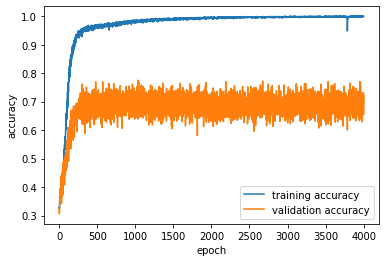

In [ ]:
import matplotlib.pyplot as plt
epochs=list(range(1,num_epochs+1))
plt.figure()
plt.plot(epochs,tr_losses,label='training accuracy')
plt.plot(epochs,te_losses,label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
print("The highest validation accuracy is: ", max(te_losses))


print("At the same epoch, the training accuracy is: ", tr_losses[te_losses.index(max(te_losses))])

The highest validation accuracy is:  0.775390625
At the same epoch, the training accuracy is:  0.9821428571428571
